In [126]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit

from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as R

In [127]:
#Earth has an atmosphere and some gravity
atmosphere = COESA76()
mu = Earth.k.to(u.km**3/u.s**2).value
density=  0

#starship entry coefficients
flat_area = 665 * (u.m**2)
dry_mass = 163*1e3 * u.kg
a_m = (flat_area/dry_mass).value

AoA = 60


#lifting area is reduced by some factor from drag area
a_m_l = ((flat_area/dry_mass)*0.75).value

#typical hypersonic regime, lift coefficient is ~ 3.7, drag ~ 9.5, l/d ~ 0.4    
# or, c_l = ~0.45, & c_d = 0.9 at AoA 60
# c_d =8.5
# c_l=4
d_factor = 0.12
c_d = 8
c_l = 4.3


Speed at periapsis is 12.007663914565818 km / s
Periapsis is 76.20000000000073 km


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



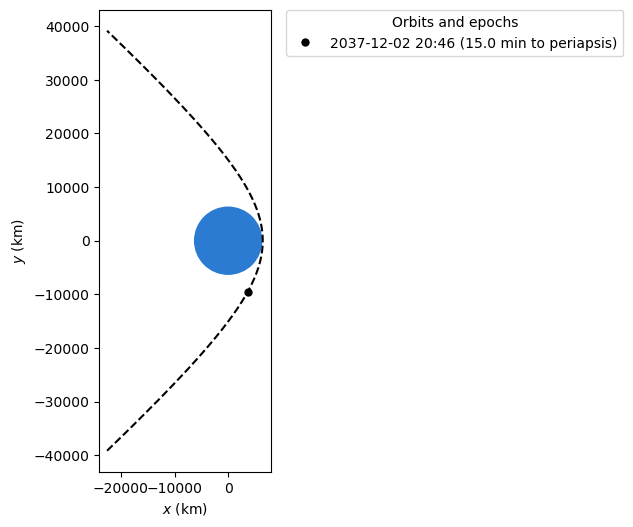

In [128]:
body_2 = Earth
#generate the hyperbolic entry orbit from the C3 calculated in the interplanerary traj
c3_a = 20.67*(u.km**2)/(u.s**2)#arrival C3
r_p = 76.2*u.km#arrival periapsis
date_arrival = time.Time("2037-12-02 21:01", scale="utc").tdb

a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

initial_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)
time_to_entry = 15*u.min

#initial_orbit = Orbit.from_vectors(Earth,p,v)
periapsis_orb = initial_orbit.propagate(-time_to_entry)
print(f"Speed at periapsis is {np.linalg.norm(initial_orbit.v)}")
print(f"Periapsis is {initial_orbit.r_p-Earth.R}")

earth_ejection_plotter = StaticOrbitPlotter()
earth_ejection_plotter.plot(periapsis_orb, label=f"{time_to_entry} to periapsis", color="k")



In [129]:

#hyperbolic orb parems
# p = [3495,-12456,0]*u.km
# v = [4.237,10.812,0]*u.km / u.s


In [130]:
def stagnation_temperature(V_inf, T_inf, Cp=1000, dissociation_correction=True):
    """Calculate stagnation temperature considering real gas effects."""
    T0 = T_inf + (V_inf ** 2) / (2 * Cp)
    
    if dissociation_correction:
        # Apply empirical correction for air dissociation at high temperatures
        if T0 > 5000:
            T0 = 14000 - 5000 * np.exp(-T0 / 7000)  # Rough empirical correction
    
    return T0

def boundary_layer_edge_temperature(M, T0, gamma=1.4, real_gas=True):
    """Calculate temperature at the boundary layer edge considering real gas effects."""
    
    if real_gas:
        # For high Mach numbers, gamma decreases due to dissociation and ionization
        gamma_eff = max(1.2, 1.4 - 0.1 * np.log10(M))  # Approximate trend
    else:
        gamma_eff = gamma
    
    Te = T0 / (1 + ((gamma_eff - 1) / 2) * M ** 2)
    
    return Te

In [131]:



#Cowell propagation on the entry trajectory

prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
reentry_accs_dumb = []
stagnation_heat_fluxs = []
entry_interface = 0
reentry_angle = 0

lift_direction = 90#90 for inverted, -90 for normal, others to take roll into acount


def reentry_accel(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        alt = 1e-3*(np.linalg.norm(state)*1e3-Earth.R.value)*u.km#alt in km

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts
        global stagnation_heat_fluxs
        global reentry_accs_dumb
        global reentry_angle

        if alt<999*u.km:
            density = 0*u.kg/(u.m**3)
            if(alt>0):
                density = atmosphere.properties(alt)[2]#kg/m^3
            if(reentry_angle == 0 and alt<120*u.km):
                r_hat = p/np.linalg.norm(p)
                AoA_lift_rot = R.from_euler('z',90,degrees=True)
                #lift vector
                theta_hat = AoA_lift_rot.apply(r_hat)    
                print("Passing through entry interface.")
                reentry_angle = np.arccos(np.dot(v/norm_v,theta_hat))

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            #print((v))
            drag_acc = -0.5*density.value*square_v*1e6*c_d*a_m * v * 1e-3 / (norm_v )# km/s^2
            AoA_lift_rot = R.from_euler('z',lift_direction,degrees=True)
            #lift vector
            lift_vec = AoA_lift_rot.apply(v)
            # print(v)
            # print(f"rotate {lift_vec}")

            # lift_acc = 0*lift_vec
            # if alt<75*u.km:
            lift_acc = 0.5*a_m_l*c_l*square_v*density.value*1e6*lift_vec*1e-3/(norm_v)
            #lift_acc = lift_vec*10e-2/(norm_v)
            # print(f"lift {np.linalg.norm(lift_acc)}")
            # print(f"drag {np.linalg.norm(drag_acc)}")

            #Heat flux = 0.763*(Pr)^(-0.6)*(pmu)^(0.1)(du/dx)(h0e-hw)[1+(Le^(0.52)-1)(hd/h0e)]
            mach_vel = 275#m/s, emprical 
            mach_num = (square_v**0.5)*1e3/mach_vel

            #stagnation enthalpy ~ V_flow^2/2
            h0 = square_v*1e6*0.5
            #boundary layer edge temperature
            T0=stagnation_temperature((square_v**0.5)*1e3,atmosphere.properties(alt)[0].value)
            Te= boundary_layer_edge_temperature(mach_num,T0) 

            #viscosity at boundary layer with empirical fit
            mue = 1.45*1e-4*(Te/10000)**0.76
            #heat flux
            #p*he\sqrt{mu/(p*R)}
            qs = (density.value*h0*((mue)/(density*4.5))**0.5).value
            heat_fluxs_dumb_val = (1.9*1e-4)*((atmosphere.properties(alt)[2].value/4.5)**0.5)*((square_v*1e6)**1.5)

            #print(t0)
            orb_fin = Orbit.from_vectors(Earth, p*u.km, v*u.km/u.s,epoch = date_arrival+t0)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)
                stagnation_heat_fluxs.append(qs)
                reentry_accs_dumb.append((d_factor*np.linalg.norm(drag_acc+lift_acc)*1e3))


            #print(acc)
            return 1.0*d_factor*(drag_acc+lift_acc)
        else:
            return 0*v

    return constant_accel



lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 3000*(u.s)
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    periapsis_orb,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-14,
    ad=reentry_accel(10e-5),
    events = events
)
impact_time = 0
print(f"Reentry angle is {(180*reentry_angle)/Math.pi:.3f} degrees")

if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning:

`rtol` is too low, setting to 2.220446049250313e-14



Passing through entry interface.
Reentry angle is 5.013 degrees
Entry interface at 817.38517079102 seconds


Entry interface at 817.38517079102 seconds
Exit of entry regime at 1044.6543542474556 seconds 
Final apogee of 119713.2379219454 km
Final perigee of 76.29956363193378 km
Energy lost of 20.527196484992835 km2 / s2
Compares to normal ~30km^2/s^2 of LEO reentry


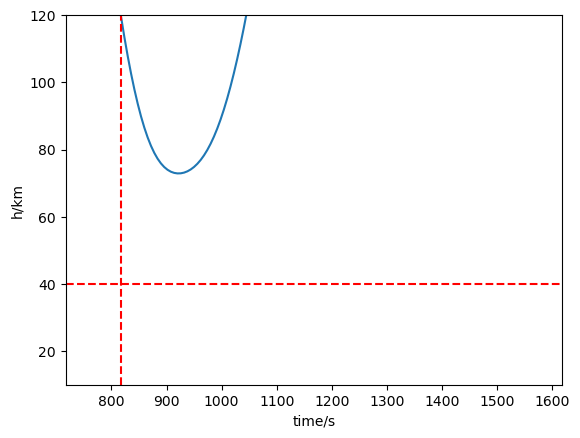

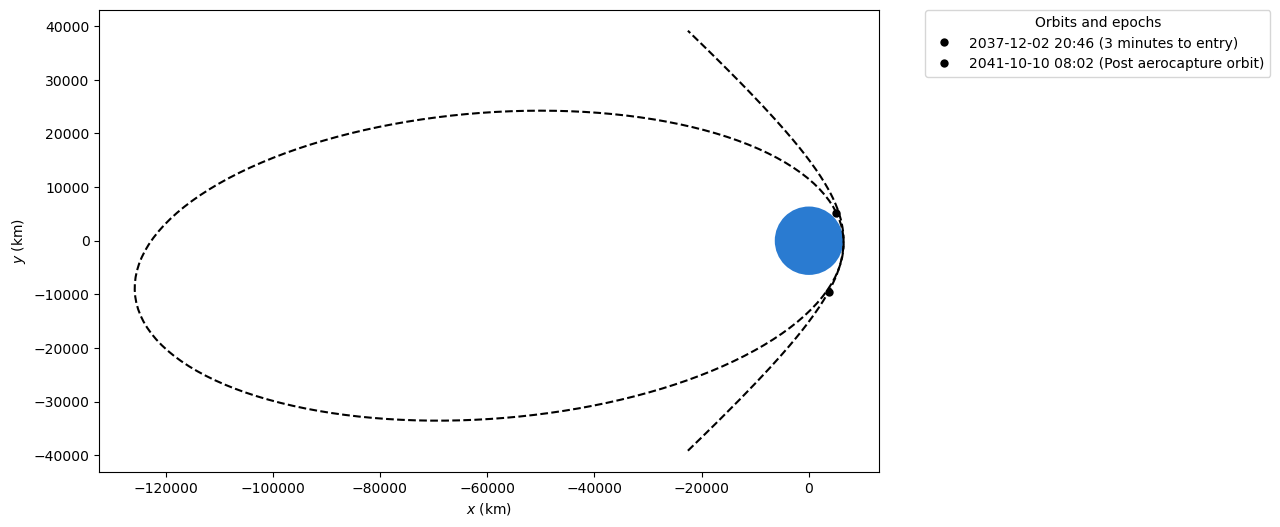

In [132]:
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")
else:
    print(f"Exit of entry regime at {reentry_time[len(reentry_time)-1]} seconds ")

print(f"Final apogee of {orb_fin.r_a-Earth.R}")
print(f"Final perigee of {orb_fin.r_p-Earth.R}")
energy_lost = 0.5*(np.linalg.norm(initial_orbit.v)**2-np.linalg.norm(orb_fin.v)**2)
print(f"Energy lost of {energy_lost}")
print(f"Compares to normal ~30km^2/s^2 of LEO reentry")


plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
#plt.axhline(impact_time)

#plt.xlim(12500,14000)
#plt.ylim(top = 100)
plt.plot(tofs, pos_spherical.distance - Earth.R)
plt.xlim(left=entry_interface-100,right=entry_interface+800)
plt.axvline(x=entry_interface,color = 'r',label='entry_interface',linestyle = '--')
plt.axhline(y=40,color = 'r',label='entry_interface',linestyle = '--')
plt.ylim(bottom = 10,top=120)
#plt.axvline(x=entry_interface,color = 'r',label='entry_interface')
plt.show()

final_orb_plotter = StaticOrbitPlotter()
final_orb_plotter.plot(periapsis_orb, label="3 minutes to entry", color="k")
final_orb_plotter.plot(orb_fin, label="Post aerocapture orbit", color="k")


In [133]:
#calculate the accelerations
reentry_accs = np.diff(np.array(reentry_vel))/np.diff(np.array(reentry_time)+1)


C:\Users\jacki\AppData\Local\Temp\ipykernel_26052\2518044004.py:2: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\jacki\AppData\Local\Temp\ipykernel_26052\2518044004.py:2: RuntimeWarning:

invalid value encountered in true_divide



In [134]:
#force times to integers,a nd then remove doubles
int_times = np.array(reentry_time).astype(int)

#print(int_times)

def remove_duplicates(arr1, arr2):
    """
    Removes duplicate entries from arr1 and their corresponding indices in arr2.

    Parameters:
        arr1 (numpy.ndarray): Array to remove duplicates from.
        arr2 (numpy.ndarray): Array with corresponding indices to remove.

    Returns:
        tuple: Filtered arr1 and arr2 with duplicates removed.
    """
    if arr1.shape != arr2.shape:
        raise ValueError("Both arrays must have the same shape")

    # Find unique values and their indices in arr1
    unique_values, unique_indices = np.unique(arr1, return_index=True)

    # Use the indices to filter arr2 as well
    filtered_arr1 = arr1[unique_indices]
    filtered_arr2 = arr2[unique_indices]

    return filtered_arr1, filtered_arr2


t_final,a_final = remove_duplicates(int_times[:-1],np.array(reentry_accs))

Entry interface at 817.38517079102 seconds


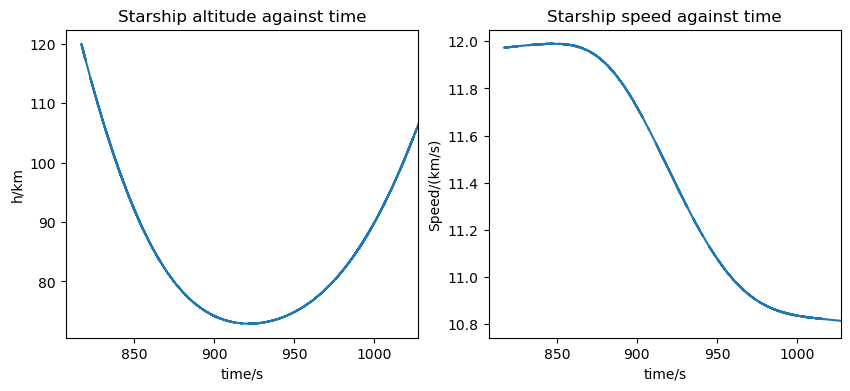

In [135]:
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_title("Starship altitude against time")
ax1.set_xlabel("time/s")
ax1.set_xlim(left = entry_interface, right=entry_interface+700)
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
ax1.set_xlim(left = entry_interface-10, right=entry_interface+210)

ax1.plot(np.array(reentry_time),np.array(reentry_alts))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
#plt.ylim(15)
ax2.set_title("Starship speed against time")
ax2.set_xlabel("time/s")
ax2.set_ylabel("Speed/(km/s)")
ax2.set_xlim(left = entry_interface-10, right=entry_interface+210)
ax2.plot(np.array(reentry_time),np.array(reentry_vel))



[        nan        -inf         inf ... -0.00075896 -0.00075887
 -0.00075896]
Max acceleration is 15.15m/s^2 or 1.54g
Max heat flux is 412.34kW/m^2


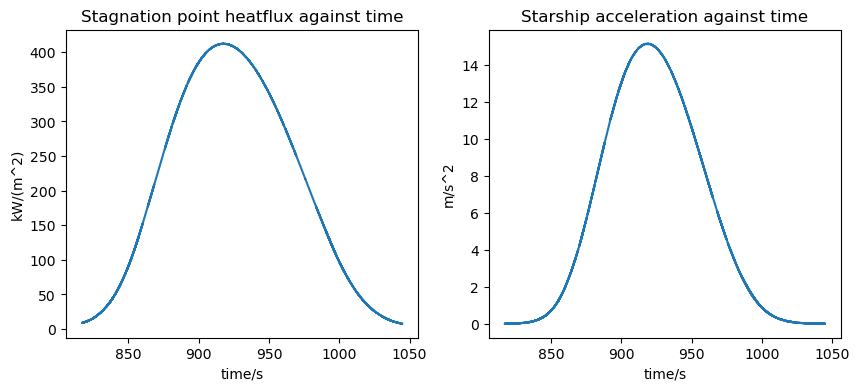

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


from scipy.signal import savgol_filter

def smooth_data(data, window_length=3, polyorder=2):
    """
    Smoothes the input data using a Savitzky-Golay filter.

    Parameters:
        data (array-like): The data to be smoothed (e.g., acceleration values).
        window_length (int): Length of the filter window (must be odd and > polyorder).
        polyorder (int): Order of the polynomial used to fit the samples.

    Returns:
        smoothed_data (ndarray): The smoothed data.
    """
    # Ensure window_length is odd and valid
    if window_length % 2 == 0:
        window_length += 1
    
    # Apply Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_length, polyorder=polyorder)
    print(smoothed_data)
    return smoothed_data

reentry_accs_smooth = smooth_data(np.array(reentry_accs))

ax1.set_ylabel("kW/(m^2)")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
#ax1.set_xlim(2600)
ax1.set_title("Stagnation point heatflux against time")
# ax1.set_ylim(top = 3, bottom = -25)
ax1.plot(np.array(reentry_time),np.array(stagnation_heat_fluxs))
ax2.set_title("Starship acceleration against time")
# ax2.set_ylim(top = 95, bottom = -0)
ax2.set_ylabel("m/s^2")
ax2.set_xlabel("time/s")
ax2.plot(np.array(reentry_time),np.array(reentry_accs_dumb))
max_acc = np.max(np.array(reentry_accs_dumb))
max_flux = np.max(np.array(stagnation_heat_fluxs))

print(f"Max acceleration is {max_acc:.2f}m/s^2 or {max_acc/9.81:.2f}g")
print(f"Max heat flux is {max_flux:.2f}kW/m^2")

# ax2.plot(t_final,a_final*1000, marker='o', linewidth=0.001)
#print(np.array(reentry_time))


In [137]:
sigma = 5.67*1e-8
temp = 1650
w_e = sigma*temp**4/1000
print(f"Radiated flux of Starship tile at peak temperature is {w_e}KW/m^2")

print(f"Acceleration to stay in circular orbit at entry interface at 11.5km/s is ~{(11500**2)/(6390000):.2f}m/s^2")



Radiated flux of Starship tile at peak temperature is 420.260754375KW/m^2
Acceleration to stay in circular orbit at entry interface at 11.5km/s is ~20.70m/s^2
